In [1]:
#!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
#!pip install torch_geometric
#!pip install pyvista
#%pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-2.0.1+cpu.html

In [2]:
import torch
import matplotlib.pyplot as plt
from utils import DelaunayTransform
from torch_geometric.data import Data
import pyvista as pv
import numpy as np
import pandas as pd
torch.__version__

/home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/libpyg.so: undefined symbol: _ZN3c109TupleTypeC1ESt6vectorINS_4Type24SingletonOrSharedTypePtrIS2_EESaIS4_EESt8optionalINS_13QualifiedNameEESt10shared_ptrINS_14FunctionSchemaEE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/libpyg.so: undefined symbol: _ZN3c109TupleTypeC1ESt6vectorINS_4Type24SingletonOrSharedTypePtrIS2_EESaIS4_EESt8optionalINS_13QualifiedNameEESt10shared_ptrINS_14FunctionSchemaEE
  warnings.warn(f"An issue occurred while importing 'torch-spar

'2.0.1+cu117'

In [3]:
import random
N = 150_000
pos = torch.rand((N, 2))
data = Data(pos=pos, surf=torch.full((N, 1), False))
transform = DelaunayTransform()
data = transform(data)
data.pos = pos

data = torch.load('./sampleData.pth')

def plot_graph(data, l=1, plotter=None):
    c = ['r', 'g', 'b', 'm']
    
    p = pv.Plotter() if plotter is None else plotter
    
    mesh = pv.PolyData()
    if data.pos.shape[1] != 3:
        mesh.points = np.concatenate([data.pos.numpy(), np.full((data.pos.shape[0], 1), l)], axis=1) 
    else:
        mesh.points = data.pos.numpy()
    edges = data.edge_index.t().numpy()
    lines = np.hstack([np.full((edges.shape[0], 1), 2), edges]).ravel()
    mesh.lines = lines
    p.add_mesh(mesh, line_width=1, color=random.choice(c))
    
    if plotter is None:
        p.show()

/home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


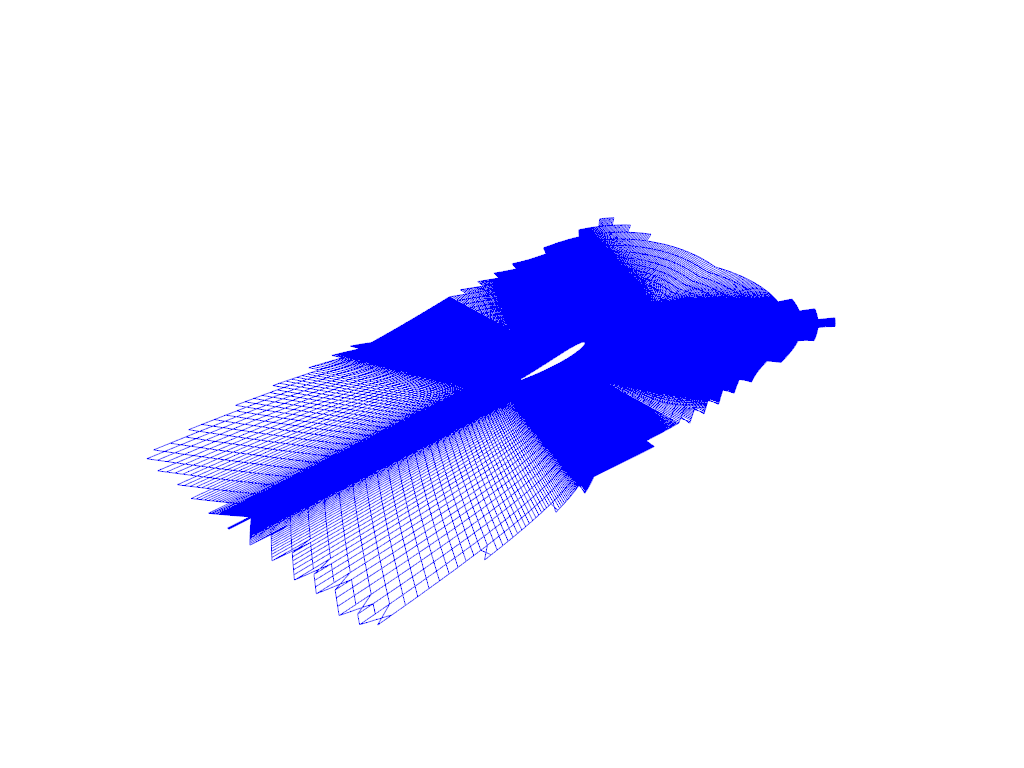

In [4]:
plot_graph(data)

In [5]:
import time
# TODO/ vérifier les direction des edges dans le papier
def divide_mesh(v: torch.Tensor, e: torch.Tensor, k: int):
    """Divide a mesh into k clusters of edges according to their direction.

    Args:
        v (Tensor(N, 2)): Positions of the vertices in the mesh.
        e (Tensor(2, N)): Edge indices of the mesh.
        k (int): Number of clusters to divide the mesh into.

    Returns:
        
    """
    clusters = [Data(edge_ids=set()) for _ in range(k)]
    
    # Randomly initialize centroids (2D points)
    centroids = torch.rand((k, 2), device=v.device)

    # Precompute edge directions and norms
    edges_directions = v[e[:, 1]] - v[e[:, 0]]
    edges_norms = torch.norm(edges_directions, dim=1, keepdim=True)  # Shape: [num_edges, 1]
    edges_directions /= edges_norms  # Normalize edge directions
    start_all = time.time()
    norm_changes = float('inf')
    while norm_changes > 1e-3:
        # Vectorized clustering step
        centroids_norms = torch.norm(centroids, dim=1, keepdim=True)  # Shape: [num_centroids, 1]
        cosine_angles = torch.matmul(edges_directions, centroids.T) / (centroids_norms.T)  # Shape: [num_edges, num_centroids]
        angles = torch.acos(cosine_angles)  # Ensure values are in valid range for acos
        min_edge_idxs = torch.argmin(angles, dim=1)  # Shape: [num_edges]
        # Efficient assignment to clusters using torch
        cluster_masks = [(min_edge_idxs == i) for i in range(k)]
        for i in range(k):
            clusters[i].edge_ids.update(torch.nonzero(cluster_masks[i]).squeeze(1).tolist())

        # Efficient centroid update
        n_m = 0.0
        for i in range(k):
            if clusters[i].edge_ids:  # Check if the cluster has assigned edges
                cluster_edges = edges_directions[torch.tensor(list(clusters[i].edge_ids), device=v.device)]
                last_centroid = centroids[i].clone()
                centroids[i] = torch.mean(cluster_edges, dim=0)
                n_m = max(torch.norm(centroids[i] - last_centroid), n_m)
        norm_changes = n_m

    # Post-process clusters to finalize edge indices
    for cluster in clusters:
        cluster.edge_index = e[list(cluster.edge_ids)]
        del cluster.edge_ids

    return clusters


device = torch.device('cpu')
data.pos = data.pos[:, :2].to(device) 
clusters = divide_mesh(data.pos, data.edge_index.T, 8)
clusters

[Data(edge_index=[191321, 2]),
 Data(edge_index=[22925, 2]),
 Data(edge_index=[49521, 2]),
 Data(edge_index=[22518, 2]),
 Data(edge_index=[48298, 2]),
 Data(edge_index=[101533, 2]),
 Data(edge_index=[14737, 2]),
 Data(edge_index=[14042, 2])]

: 

In [6]:
%%time

import torch
from torch_cluster import grid_cluster
from torch_scatter import scatter

def generate_coarse_graph(data, r):
    """Generate a coarse graph from a fine graph.

    Args:
        data (Data): The fine graph to coarsen.
        r (_type_): _description_

    Returns:
        _type_: _description_
    """
    #FIXME: use square grid 
    size = torch.max(data.pos, dim=0)[0] - torch.min(data.pos, dim=0)[0]

    size /= r
    
    # Assign each node to a grid cell id
    cluster = grid_cluster(data.pos, size) 
    
    # Get the indices of the unique clusters
    unique_indices, new_index = torch.unique(cluster, return_inverse=True)
    # Gather each node to its cluster and compute the mean for position features
    out_positions = scatter(data.pos.t(), new_index, reduce='mean')
    
    out_x = scatter(data.x.t(), new_index, reduce='mean')
    

    # Interpolate the other features accordingly to the position    
    surf = scatter(data.surf.to(torch.int), new_index, reduce='max')
    edge_index = torch.stack([new_index+data.num_nodes, torch.arange(0, new_index.shape[0])], dim=0)
    
    #edge_clusters = divide_mesh(out_positions.t(), edge_index, 6)
    return transform(Data(pos=out_positions.t()[:, :2], x=out_x.t(), surf=surf)), edge_index
    
def generate_coarse_graphs(data, R: int):
    range_ = 5000
    base = data.clone()
    base.pos = torch.concatenate([base.pos, torch.full((base.pos.shape[0], 1), 1)], axis=1)
    for i in range(2, R+1):
        subgraph, connection_index = generate_coarse_graph(data, range_//(5**i)) # TODO: choose the right scale factor
        subgraph.pos = torch.concatenate([subgraph.pos, torch.full((subgraph.pos.shape[0], 1), i)], axis=1)
        subgraph.edge_index = torch.add(subgraph.edge_index, base.pos.shape[0])
        print("a", base.pos.shape, connection_index.shape, flush=True)
        connection_index = torch.add(connection_index, base.pos.shape[0])
        print("b")
        data = subgraph.clone()
        base.pos = torch.cat([base.pos, subgraph.pos], dim=0)
        
        base.edge_index = torch.cat([base.edge_index, subgraph.edge_index], dim=1)
        base.edge_index = torch.cat([base.edge_index, connection_index ], dim=1)
        
    return base
    
plot_graph(generate_coarse_graphs(data, 3))

a torch.Size([170180, 3]) torch.Size([2, 170180])
b
a torch.Size([182268, 3]) torch.Size([2, 12088])
